# Install, Paths and Parameters

In [1]:
import os
from pathlib import Path
import getpass
import numpy as np
import pandas as pd
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torchattacks
from torchattacks import *
from tqdm import tqdm
import random
import sys

# allow imports when running script from within project dir
[sys.path.append(i) for i in ['.', '..']]

# local
# from src.helpers.helpers import get_random_indexes, get_random_classes
from src.model.dino_model import get_dino, ViTWrapper
from src.model.data import *
from src.model.train import *

# seed
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

DATA_PATH = Path('/','cluster', 'scratch', 'thobauma', 'dl_data')
MAX_PATH = Path('/','cluster', 'scratch', 'mmathys', 'dl_data')

LOG_BASE_PATH = Path(MAX_PATH, 'logs')

# DamageNet
DN_PATH = Path(DATA_PATH, 'damageNet')
DN_LABEL_PATH = Path(DN_PATH, 'val_damagenet.txt')
DN_IMAGES_PATH = Path(DN_PATH, 'images')

# Image Net
ORI_PATH = Path(DATA_PATH, 'ori_data')
CLASS_SUBSET_PATH = Path(ORI_PATH, 'class_subset.npy')

VAL_PATH = Path(ORI_PATH, 'validation')
VAL_IMAGES_PATH = Path(VAL_PATH,'images')
VAL_LABEL_PATH = Path(VAL_PATH, 'correct_labels.txt')

TRAIN_PATH = Path(ORI_PATH, 'train')
TRAIN_IMAGES_PATH = Path(TRAIN_PATH,'images')
TRAIN_LABEL_PATH = Path(TRAIN_PATH, 'correct_labels.txt')

In [2]:
# If CLASS_SUBSET is specified, INDEX_SUBSET will be ignored. Set CLASS_SUBSET=None if you want to use indexes.
# INDEX_SUBSET = get_random_indexes(number_of_images = 50000, n_samples=1000)
# CLASS_SUBSET = get_random_classes(number_of_classes = 10, min_rand_class = 1, max_rand_class = 1001)


CLASS_SUBSET = np.load(CLASS_SUBSET_PATH)
CLASS_SUBSET = CLASS_SUBSET[:3]


NUM_WORKERS= 0
PIN_MEMORY=True

BATCH_SIZE = 64

DEVICE = 'cuda'

In [3]:
CLASS_SUBSET

array([103, 436, 861])

# Load data

In [4]:
# Remember to set the correct transformation

train_dataset = AdvTrainingImageDataset(TRAIN_IMAGES_PATH, TRAIN_LABEL_PATH, ADVERSARIAL_TRAINING_TRANSFORM, CLASS_SUBSET, index_subset=None)
val_dataset = AdvTrainingImageDataset(VAL_IMAGES_PATH, VAL_LABEL_PATH, ORIGINAL_TRANSFORM, CLASS_SUBSET, index_subset=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False)

print(f'train:      {len(train_dataset)}\nvalidation:  {len(val_dataset)}')

train:      3872
validation:  150


# Get Model, Classifier
Official repo: https://github.com/facebookresearch/dino

In [5]:
model, base_linear_classifier = get_dino()

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Model vit_small built.
Embed dim 1536
We load the reference pretrained linear weights from dino_deitsmall16_pretrain/dino_deitsmall16_linearweights.pth.


In [6]:
# Define and load pretrained weights for linear classifier on ImageNet
from torch import nn
class LinearClassifier(nn.Module):
    """Linear layer to train on top of frozen features"""
    def __init__(self, dim, num_labels=1000, hidden_size=512):
        super(LinearClassifier, self).__init__()
        self.num_labels = num_labels
        self.linear = nn.Linear(dim, hidden_size) 
        self.linear2 = nn.Linear(hidden_size, num_labels) 
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()
        self.linear2.weight.data.normal_(mean=0.0, std=0.01)
        self.linear2.bias.data.zero_()

        self.relu = nn.ReLU()

    def forward(self, x):
        # flatten
        x = x.view(x.size(0), -1)

        # linear layer
        x = self.relu(self.linear(x))
        return self.linear2(x)

# Sanity Check

In [7]:
n_classifier = LinearClassifier(base_linear_classifier.linear.in_features, num_labels=len(CLASS_SUBSET))
n_classifier = n_classifier.cuda()

In [8]:
LOG_PATH = Path(LOG_BASE_PATH, 'original')

In [25]:
n_loggers = train(model, 
                linear_classifier,
                train_loader,
                val_loader, 
                LOG_PATH, 
                epochs=4,
#                adversarial_attack=train_attack
               )

Epoch: [0]  [ 0/82]  eta: 0:01:09  lr: 0.000063  loss: 1.373617 (1.373617)  time: 0.851379  data: 0.684152  max mem: 5504
Epoch: [0]  [20/82]  eta: 0:00:49  lr: 0.000063  loss: 1.309737 (1.302602)  time: 0.795823  data: 0.678475  max mem: 5504
Epoch: [0]  [40/82]  eta: 0:00:33  lr: 0.000063  loss: 1.080016 (1.191894)  time: 0.815699  data: 0.698275  max mem: 5504
Epoch: [0]  [60/82]  eta: 0:00:17  lr: 0.000063  loss: 0.836695 (1.078067)  time: 0.786554  data: 0.670188  max mem: 5504
Epoch: [0]  [80/82]  eta: 0:00:01  lr: 0.000063  loss: 0.627658 (0.968912)  time: 0.781676  data: 0.665395  max mem: 5504
Epoch: [0]  [81/82]  eta: 0:00:00  lr: 0.000063  loss: 0.627252 (0.963540)  time: 0.756938  data: 0.644937  max mem: 5504
Epoch: [0] Total time: 0:01:04 (0.788933 s / it)
Averaged stats: lr: 0.000063  loss: 0.627252 (0.963540)
Test:  [0/4]  eta: 0:00:03  loss: 1.646107 (1.646107)  acc1: 35.937500 (35.937500)  time: 0.762103  data: 0.645859  max mem: 5504
Test:  [3/4]  eta: 0:00:00  loss:

# PGD

In [9]:
pgd_classifier = LinearClassifier(base_linear_classifier.linear.in_features, num_labels=len(CLASS_SUBSET)).cuda()

In [10]:
vits = ViTWrapper(model, pgd_classifier)

In [12]:
# Define attack used for adversarial training
train_attack = PGD(vits, eps=0.1, alpha=2/255, steps=15)

In [13]:
LOG_PATH = Path(LOG_BASE_PATH, 'pgd','03_c3')

In [14]:
loggers = train(model, 
                pgd_classifier,
                train_loader,
                val_loader, 
                LOG_PATH, 
                epochs=4,
                adversarial_attack=train_attack
               )

Epoch: [0]  [ 0/61]  eta: 0:05:09  lr: 0.000063  loss: 4.217352 (4.217352)  time: 5.071331  data: 0.753359  max mem: 5389
Epoch: [0]  [20/61]  eta: 0:03:21  lr: 0.000063  loss: 3.038402 (3.249791)  time: 4.894910  data: 0.641301  max mem: 5470
Epoch: [0]  [40/61]  eta: 0:01:43  lr: 0.000063  loss: 2.053930 (2.674878)  time: 4.918339  data: 0.633523  max mem: 5470
Epoch: [0]  [60/61]  eta: 0:00:04  lr: 0.000063  loss: 1.629464 (2.337680)  time: 4.775075  data: 0.600629  max mem: 5470
Epoch: [0] Total time: 0:04:56 (4.866284 s / it)
Averaged stats: lr: 0.000063  loss: 1.629464 (2.337680)
Test:  [0/3]  eta: 0:00:15  loss: 1.022584 (1.022584)  acc1: 89.062500 (89.062500)  adv_loss: 1.495088 (1.495088)  adv_acc1: 0.000000 (0.000000)  time: 5.133814  data: 0.723655  max mem: 5506
Test:  [2/3]  eta: 0:00:04  loss: 1.022584 (1.021745)  acc1: 90.909096 (90.666667)  adv_loss: 1.495088 (1.496707)  adv_acc1: 0.000000 (0.000000)  time: 4.071517  data: 0.605155  max mem: 5506
Test: Total time: 0:00:

KeyboardInterrupt: 

In [11]:
validation_attack = PGD(vits, eps=0.6, alpha=2/255, steps=15)

In [14]:
log_dict, logs = validate_network(model, 
                linear_classifier, 
                val_loader,
                tensor_dir=None,
                adversarial_attack=validation_attack)

Test:  [ 0/10]  eta: 0:00:13  loss: 0.094194 (0.094194)  acc1: 100.000000 (100.000000)  time: 1.385940  data: 0.230570  max mem: 1422
Test:  [ 9/10]  eta: 0:00:01  loss: 0.098080 (0.105388)  acc1: 100.000000 (99.333333)  time: 1.242715  data: 0.197191  max mem: 1422
Test: Total time: 0:00:12 (1.242903 s / it)
* Acc@1 99.333 loss 0.105


# Plotting

In [17]:
inp, target, name = next(iter(val_loader))

In [18]:
inp = inp.cuda(non_blocking=True)
target = target.cuda(non_blocking=True)
out = train_attack(inp, target)

In [19]:
import matplotlib.pyplot as plt

def imshow(img, title):
    img = img.to('cpu')
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

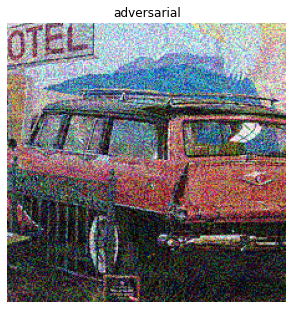

In [20]:
imshow(out[0], 'adversarial')

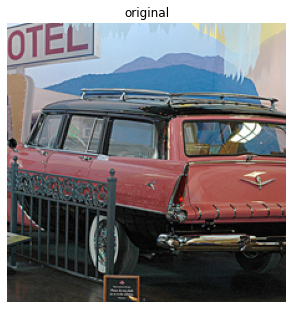

In [21]:
imshow(inp[0], 'original')

In [27]:
log_dict, logs = validate_network(model, 
                linear_classifier, 
                val_loader,
                tensor_dir=None,
                adversarial_attack=train_attack)

Test:  [ 0/10]  eta: 0:00:14  loss: 1.091493 (1.091493)  acc1: 50.000000 (50.000000)  adv_loss: 1.106042 (1.106042)  adv_acc1: 0.000000 (0.000000)  time: 1.487029  data: 0.270818  max mem: 1456
Test:  [ 9/10]  eta: 0:00:01  loss: 1.095770 (1.097160)  acc1: 50.000000 (50.666667)  adv_loss: 1.112605 (1.113430)  adv_acc1: 0.000000 (0.666667)  time: 1.315169  data: 0.228885  max mem: 1456
Test: Total time: 0:00:13 (1.315430 s / it)
* Acc@1 50.667 loss 1.097
* adv_Acc@1 0.667 adv_loss 1.113
